In [42]:
import torch
import torchvision


device = "cuda"

model = torchvision.models.get_model(
    "ssdlite320_mobilenet_v3_large", 
    weights=None, 
    weights_backbone='IMAGENET1K_V2', 
    num_classes=3,
)
model.to(device)

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [43]:
checkpoint = torch.load('pretrained_8000_5/checkpoint.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [44]:
backbone = model.backbone

In [45]:
import presets
from coco_utils import get_coco

def get_dataset(is_train):
    image_set = "train" if is_train else "val"
    num_classes, mode = (3, "circor")
    with_masks = False
    ds = get_coco(
        root='datasets/spec_8000_5/non_cropped',
        image_set=image_set,
        transforms=get_transform(is_train),
        mode=mode,
        use_v2=False,
        with_masks=with_masks,
    )
    print(ds)
    return ds, num_classes


def get_transform(is_train):
    return presets.DetectionPresetEval(backend='PIL', use_v2=False)

In [46]:
import utils


dataset_test, _ = get_dataset(is_train=False)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, sampler=test_sampler, num_workers=4, collate_fn=utils.collate_fn
)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Dataset CocoDetection
    Number of datapoints: 948
    Root location: datasets/spec_8000_5/non_cropped/val2017


In [47]:
backbone

SSDLiteFeatureExtractorMobileNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2

In [71]:
results = []
n_threads = torch.get_num_threads()
torch.set_num_threads(1)
backbone.eval()

with torch.no_grad():
    for image, target in data_loader_test:
        image = image[0].to(device)
        image = torch.unsqueeze(image, 0)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        features = backbone(image)
        features = features['5']
        features = torch.flatten(features)
        results.append(features.to('cpu'))

In [72]:
results[0].shape

torch.Size([256])

In [78]:
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
cluster = np.array(tsne.fit_transform(np.array(results)))

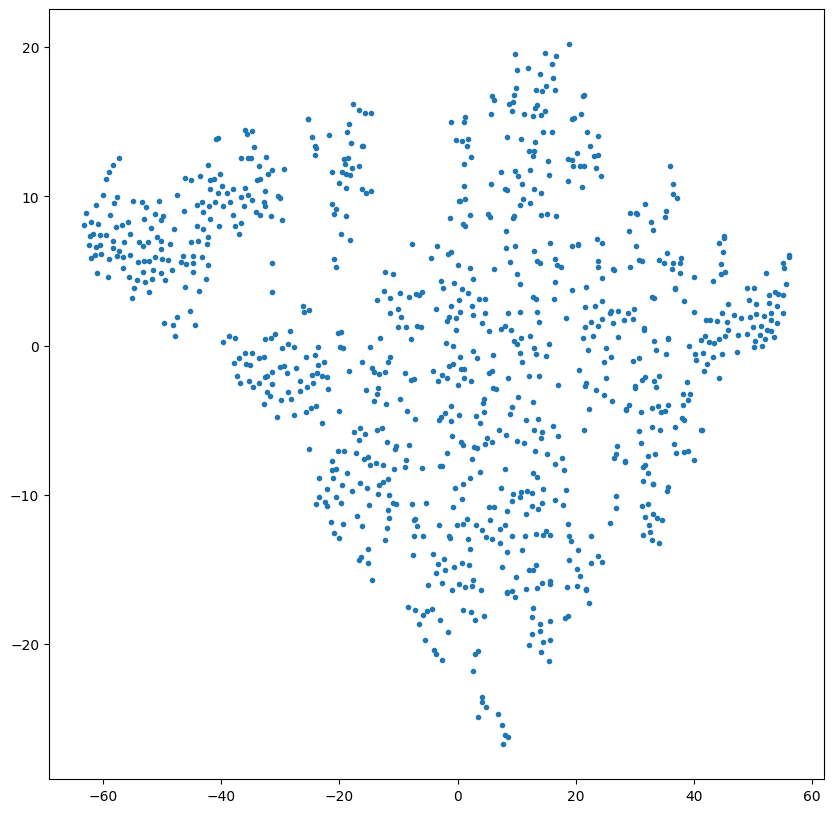

In [82]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

plt.scatter(cluster[:, 0], cluster[:, 1], marker='.')

plt.show()